# Finding Center and Radius of Circles
Anshul Gupta | 10 July 2020

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import optimize

## Getting Image
The goal is to find the radius and center of the outermost circle to determine if the emitter in the center is
concentric.

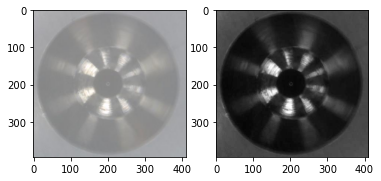

In [2]:
image = cv2.cvtColor(cv2.imread("Input\image13.jpeg"), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# gray = cv2.equalizeHist(gray)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(gray, 'gray')

## Find Edges
We find the edges using a simple Canny Edge Detector.

However, because of the lighting, contrast, and other factors, the edges are very noisy. But this can be worked around.

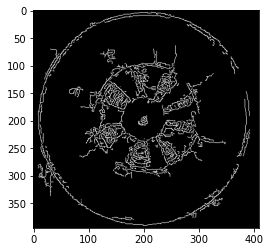

In [3]:
edges = cv2.Canny(gray, 0, 35)

plt.figure()
plt.imshow(edges, 'gray')

## Scan Edges From All Directions
We scan the edges from all directions to get the outermost edges.

For example, for the top scan, we grab the uppermost edges for each x location.

However, the noise and holes in the edges creates bumps and holes in the curves.

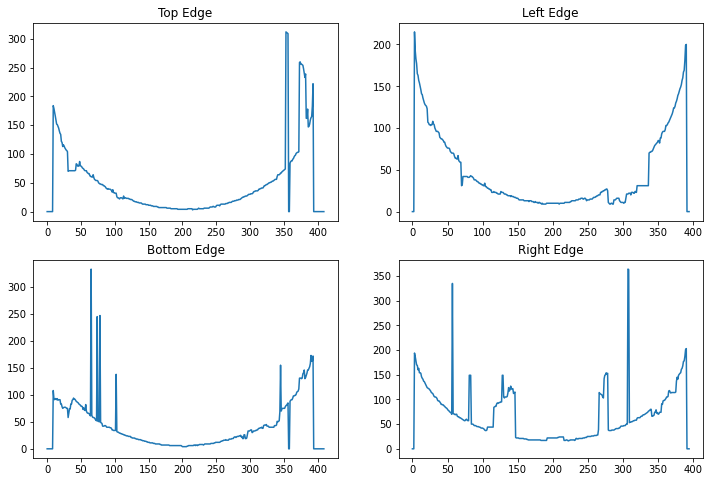

In [4]:
top_edge = np.argmax(edges, axis=0)
left_edge = np.argmax(edges, axis=1)
bot_edge = np.argmax(np.flipud(edges), axis=0)
right_edge = np.argmax(np.fliplr(edges), axis=1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('Top Edge')
plt.plot(np.arange(0, len(top_edge), dtype=np.uint16), top_edge)
plt.subplot(2, 2, 2)
plt.title('Left Edge')
plt.plot(np.arange(0, len(left_edge), dtype=np.uint16), left_edge)
plt.subplot(2, 2, 3)
plt.title('Bottom Edge')
plt.plot(np.arange(0, len(bot_edge), dtype=np.uint16), bot_edge)
plt.subplot(2, 2, 4)
plt.title('Right Edge')
plt.plot(np.arange(0, len(right_edge), dtype=np.uint16), right_edge)

## Fit Circle to Edge Curve
To eliminate this noise, we fit a circle to each curve so outlying points can be identified and removed.

The example below is on the top edge.

The functions below are helpers for the optimization.

In [5]:
x, y = np.arange(0, len(top_edge), dtype=np.uint16), top_edge.copy()

def calc_R(xc, yc):
    return np.sqrt((x - xc) ** 2 + (y - yc) ** 2)

def f(c):
    ri = calc_R(*c)
    return ri - ri.mean()

### Fit Circle
Using least squared fitting, we find a circle that fits the points.

But we can see from the Fit graph that the circle is an awful fit. This is because of the bumps and noise that is
influencing the fitting too much.

Center: [203.59529393 196.35157153] | Radius: 198.50809159806133


C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


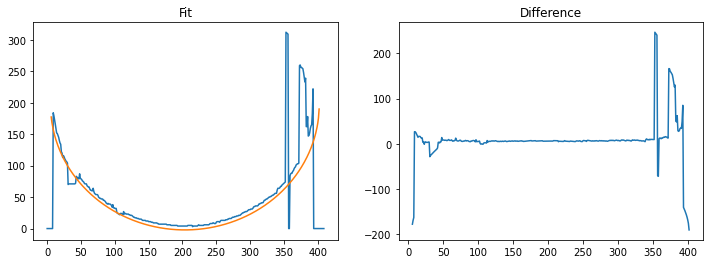

In [6]:
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
print("Center:", center, "| Radius:", r)
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y)
plt.plot(x, y_c)
plt.title('Fit')
plt.subplot(1, 2, 2)
plt.title('Difference')
plt.plot(x, y - y_c)

### Remove Outliers and Refit
To stop these outliers, we remove any point with a large difference from the fitted curve, and we refit.
This results in a significantly better fit to what we expect the circle to be.

However, there are still bumps that could be smoothed out.

Center: [202.20189997 200.63176199] | Radius: 196.67582592560026


C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


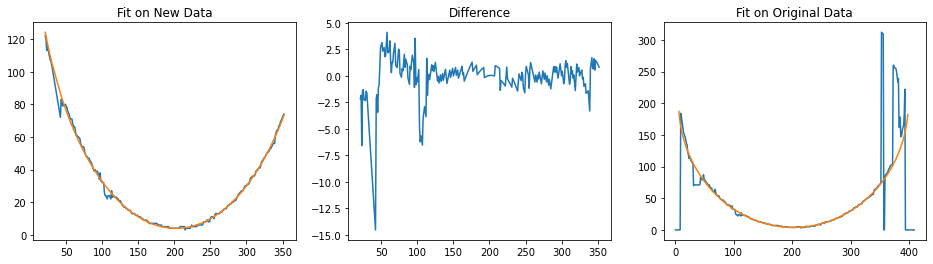

In [7]:
diff = y - y_c
x = x[abs(diff) < 10]
y = y[abs(diff) < 10]
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
print("Center:", center, "| Radius:", r)
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
y_c_orig = -np.sqrt(r ** 2 - (np.arange(0, len(top_edge), dtype=np.uint16) - center[0]) ** 2) + center[1]
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title('Fit on New Data')
plt.plot(x, y)
plt.plot(x, y_c)
plt.subplot(1, 3, 2)
plt.title('Difference')
plt.plot(x, y - y_c)
plt.subplot(1, 3, 3)
plt.title('Fit on Original Data')
plt.plot(np.arange(0, len(top_edge), dtype=np.uint16), top_edge)
plt.plot(np.arange(0, len(top_edge), dtype=np.uint16), y_c_orig)

### Remove More Outliers and Refit
We do the process again, with a smaller acceptable margin to remove many outliers that may have been masked by our
original terrible fit. After refitting, this results in a significantly better fit than what we originally had. The
curve better represents the edges that represent the circle in the image.

Our window of allowed points was originally large to allow for accurate points that are not close to the original bad
fit to still be considered in future better fits. However, we become more strict later to prune out worse and worse
points.

This system can be improved to produce better fits by widening the window of accurate points in the beginning and
running more iterations of fits to allow more points to be considered in the better fits.

Center: [202.40913982 200.77773429] | Radius: 196.68946864492906


C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


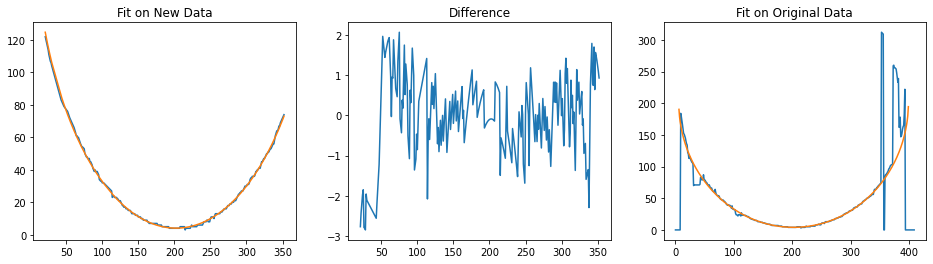

In [8]:
diff = y - y_c
x = x[abs(diff) < 2.5]
y = y[abs(diff) < 2.5]
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
print("Center:", center, "| Radius:", r)
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
y_c_orig = -np.sqrt(r ** 2 - (np.arange(0, len(top_edge), dtype=np.uint16) - center[0]) ** 2) + center[1]
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title('Fit on New Data')
plt.plot(x, y)
plt.plot(x, y_c)
plt.subplot(1, 3, 2)
plt.title('Difference')
plt.plot(x, y - y_c)
plt.subplot(1, 3, 3)
plt.title('Fit on Original Data')
plt.plot(np.arange(0, len(top_edge), dtype=np.uint16), top_edge)
plt.plot(np.arange(0, len(top_edge), dtype=np.uint16), y_c_orig)

### The Circle
We now technically have a circle that fits the curve, so why don't we stop here?

If we look at the circle on the complete image, we can see that it provides a fantastic fit for the top of the
circle, but overshoots at the bottom, which is not good.

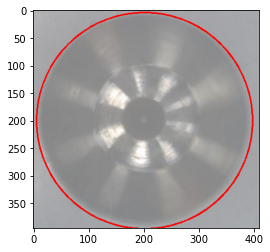

In [9]:
output = image.copy()
cv2.circle(output, tuple(center.astype('int')), int(r), (255, 0, 0), 2)
plt.figure()
plt.imshow(output)

### Get Top Point
Instead, we will get the uppermost point of the circle. If we get the leftmost, rightmost, and lowermost points of
the every other curve, we can find the center and radius more accurately.

In [10]:
top = np.nanargmin(y_c_orig), np.nanmin(y_c_orig)
print("Uppermost point of circle:", top)

Uppermost point of circle: (202, 4.088691173777249)


## Curve Fit on Each Curve
Now we have to repeat the process above for each curve scan we did.

### Left Edge

Leftmost point of circle: (9.144982303389355, 198)


C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


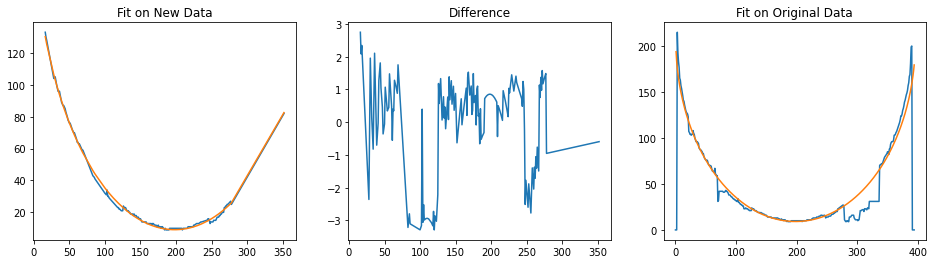

In [11]:
x, y = np.arange(0, len(left_edge), dtype=np.uint16), left_edge.copy()
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
diff = y - y_c
x = x[abs(diff) < 10]
y = y[abs(diff) < 10]
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
diff = y - y_c
x = x[abs(diff) < 2.5]
y = y[abs(diff) < 2.5]
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
y_c_orig = -np.sqrt(r ** 2 - (np.arange(0, len(left_edge), dtype=np.uint16) - center[0]) ** 2) + center[1]
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title('Fit on New Data')
plt.plot(x, y)
plt.plot(x, y_c)
plt.subplot(1, 3, 2)
plt.title('Difference')
plt.plot(x, y - y_c)
plt.subplot(1, 3, 3)
plt.title('Fit on Original Data')
plt.plot(np.arange(0, len(left_edge), dtype=np.uint16), left_edge)
plt.plot(np.arange(0, len(left_edge), dtype=np.uint16), y_c_orig)

left = np.nanmin(y_c_orig), np.nanargmin(y_c_orig)
print("Leftmost point of circle:", left)

### Bottom Edge

C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Lowermost point of circle: (206, 389.4008143328787)


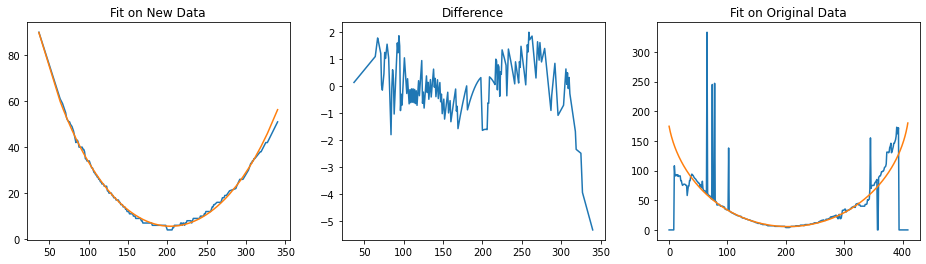

In [12]:
x, y = np.arange(0, len(bot_edge), dtype=np.uint16), bot_edge.copy()
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
diff = y - y_c
x = x[abs(diff) < 10]
y = y[abs(diff) < 10]
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
diff = y - y_c
x = x[abs(diff) < 2.5]
y = y[abs(diff) < 2.5]
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
y_c_orig = -np.sqrt(r ** 2 - (np.arange(0, len(bot_edge), dtype=np.uint16) - center[0]) ** 2) + center[1]
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title('Fit on New Data')
plt.plot(x, y)
plt.plot(x, y_c)
plt.subplot(1, 3, 2)
plt.title('Difference')
plt.plot(x, y - y_c)
plt.subplot(1, 3, 3)
plt.title('Fit on Original Data')
plt.plot(np.arange(0, len(bot_edge), dtype=np.uint16), bot_edge)
plt.plot(np.arange(0, len(bot_edge), dtype=np.uint16), y_c_orig)
bot = gray.shape[1] - np.nanargmin(y_c_orig), gray.shape[0] - np.nanmin(y_c_orig)
print("Lowermost point of circle:", bot)

### Right Edge

C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
C:\ProgramData\Anaconda3\envs\ExEmAlignment\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


Leftmost point of circle: (393.0764148419206, 195)


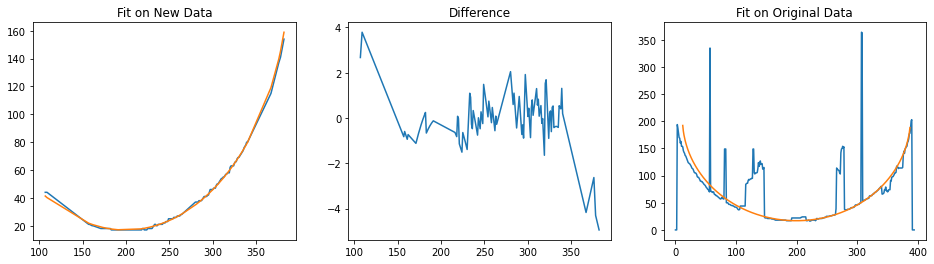

In [13]:
x, y = np.arange(0, len(right_edge), dtype=np.uint16), right_edge.copy()
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
diff = y - y_c
x = x[abs(diff) < 10]
y = y[abs(diff) < 10]
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
diff = y - y_c
x = x[abs(diff) < 2.5]
y = y[abs(diff) < 2.5]
center, _ = optimize.leastsq(f, (200, 200))
ri = calc_R(*center)
r = ri.mean()
y_c = -np.sqrt(r ** 2 - (x - center[0]) ** 2) + center[1]
y_c_orig = -np.sqrt(r ** 2 - (np.arange(0, len(right_edge), dtype=np.uint16) - center[0]) ** 2) + center[1]
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title('Fit on New Data')
plt.plot(x, y)
plt.plot(x, y_c)
plt.subplot(1, 3, 2)
plt.title('Difference')
plt.plot(x, y - y_c)
plt.subplot(1, 3, 3)
plt.title('Fit on Original Data')
plt.plot(np.arange(0, len(right_edge), dtype=np.uint16), right_edge)
plt.plot(np.arange(0, len(right_edge), dtype=np.uint16), y_c_orig)
right = gray.shape[1] - np.nanmin(y_c_orig), gray.shape[0] - np.nanargmin(y_c_orig)
print("Leftmost point of circle:", right)

## Calculate True Circle
Now that we have 4 points representing the 4 perpendicular directions of the circle. From those 4 points, we can find
 the center and the radius of the true circle.

In [14]:
center = ((top[0] + bot[0])/2, (left[1] + right[1])/2)
radius = (((right[0] - left[0]) / 2) + ((bot[1] - top[1]) / 2)) / 2
print("Top:    ", top)
print("Bottom: ", bot)
print("Left:   ", left)
print("Right:  ", right)
print("Center: ", center)
print("Radius: ", radius)

Top:     (202, 4.088691173777249)
Bottom:  (206, 389.4008143328787)
Left:    (9.144982303389355, 198)
Right:   (393.0764148419206, 195)
Center:  (204.0, 196.5)
Radius:  192.31088892440818


## Circle on Image
Now that we have a circle, we can overlay it on top of the original image. It looks like a near perfect fit and
doesn't overshoot or undershoot anywhere like previously.

The blue plus sign in the center also shows the exact center of the circle, which we can use to compare to the emitter.

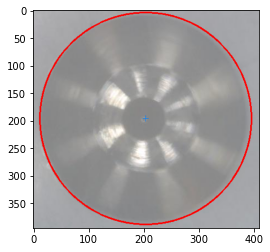

In [15]:
center = tuple(map(lambda x: int(np.round(x)), center))
output = image.copy()
cv2.circle(output, tuple(map(lambda x: int(np.round(x)), center)), int(np.round(radius)), (255, 0, 0), 2)
# cv2.rectangle(output, (center[0] - 5, center[1] - 5), (center[0] + 5, center[1] + 5), (0, 128, 255), -1)
cv2.line(output, (center[0], center[1]+5), (center[0], center[1] - 5), (0, 128, 255), 1)
cv2.line(output, (center[0]+5, center[1]), (center[0]-5, center[1]), (0, 128, 255), 1)
plt.figure()
plt.imshow(output)

## Comparing Center to Emitter
If we zoom into the emitter, we can see that the plus is slightly offset from the center of the emitter. This means
that in the image, the emitter is not at the center of the outer circle.

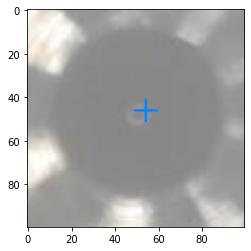

In [16]:
output = image.copy()
cv2.line(output, (center[0], center[1]+5), (center[0], center[1] - 5), (0, 128, 255), 1)
cv2.line(output, (center[0]+5, center[1]), (center[0]-5, center[1]), (0, 128, 255), 1)
crop = output[150:250, 150:250]
plt.figure()
plt.imshow(crop)

## Next Steps
Now, we have to find the center of the emitter. This may prove difficult due to the faintness of the emitter as well
as the compression that jpeg did to this image. This will probably require a new method.

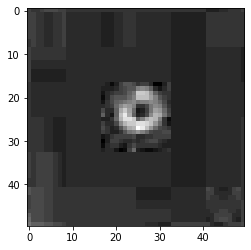

In [28]:
crop = gray[175:225, 175:225]
plt.figure()
plt.imshow(crop, 'gray')